# Machine Translation
  1. Using Encoder Decoder 

  2. Using word alignment 

In [ ]:
# Loading Dataset
ftr=open('/content/drive/My Drive/Projects/Machine Translation/small_vocab_fr','r')
ftrain=ftr.read()
ftrain=ftrain.split('\n')
ftr.close()
etr=open('/content/drive/My Drive/Projects/Machine Translation/small_vocab_en','r')
etrain=etr.read()
etrain=etrain.split('\n')
etr.close()

mean for french sentence =70.42748855731497, for english=64.90165456510543
STD for french sentence =15.674994266752229, for english=16.42720132640752


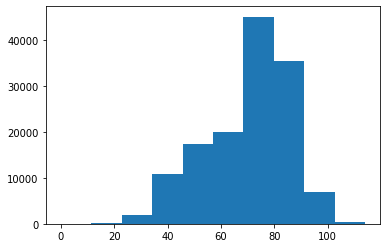

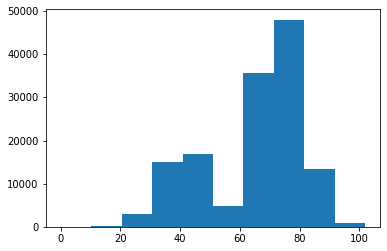

In [ ]:
# length of the sentences
import numpy as np
tempf=[]
tempe=[]
for i in ftrain:
  tempf.append(len(i))

for i in etrain:
  tempe.append(len(i))
  
print('mean for french sentence ={}, for english={}'.format(np.mean(tempf),np.mean(tempe)))
print('STD for french sentence ={}, for english={}'.format(np.std(tempf),np.std(tempe)))

import matplotlib.pyplot as plt
plt.hist(tempf,bins=10)
plt.show()
plt.hist(tempe,bins=10)
plt.show()

In [ ]:
# Text preprocessing
# We will create sequence of 100 words

import tensorflow as tf
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=10000,oov_token='<oov>')
tokenizer.fit_on_texts(ftrain)
fseq=tokenizer.texts_to_sequences(ftrain)
fpad=tf.keras.preprocessing.sequence.pad_sequences(
    fseq, maxlen=100, dtype='int32', padding='post', truncating='post',
    value=0.0)


tokenizer1=tf.keras.preprocessing.text.Tokenizer(num_words=10000,oov_token='<oov>')
tokenizer1.fit_on_texts(etrain)
eseq=tokenizer1.texts_to_sequences(etrain)
epad=tf.keras.preprocessing.sequence.pad_sequences(
    eseq, maxlen=100, dtype='int32', padding='post', truncating='post',
    value=0.0)

In [ ]:
# Finished with data preprocessing
train_input=fpad[:130000]
train_output=epad[:130000]
train_input=train_input.reshape((130000,100))
train_output=train_output.reshape((130000,100))

test_input=fpad[130000:]
test_output=epad[130000:]

Implementing the paper's archetacture without the alignment layer that is without attention. 

Paper- NEURAL MACHINE TRANSLATION
BY JOINTLY LEARNING TO ALIGN AND TRANSLATE
by - Dzmitry Bahdanau


  1. The Encoder -Decoder architecture is as follows-

  Encoder = Input --> Embedding with 16 vector size ---> Bi-Directional lstm with 100 units.
    
  Decoder = Output --> Bidirectional lstm 100 units--> softmax Dense
    

In [ ]:
import tensorflow as tf
import numpy as np


In [ ]:
tf.keras.backend.clear_session()
class Enc(tf.keras.Model):
  def __init__(self):
    super(Enc,self).__init__()
    self.emb=tf.keras.layers.Embedding(346,16)
    self.inp=tf.keras.Input(shape=(100))
    self.bilstm=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,activation='relu',return_sequences=True))

  def call(self,inputs):
    #x=self.inp(inputs)
    x=self.emb(inputs)
    x=self.bilstm(x)
    return x


In [ ]:
class Dec(tf.keras.Model):
  def __init__(self):
    super(Dec,self).__init__()
    self.bilstm=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,activation='relu',return_sequences=True))
    self.d1=tf.keras.layers.Dense(201,activation='sigmoid')

  def call(self,inputs):
    x=self.bilstm(inputs)
    x=self.d1(x)
    return x


In [ ]:
class EncDec(tf.keras.Model):
  def __init__(self):
    super(EncDec,self).__init__()
    self.enc=Enc()
    self.dec=Dec()
  def call(self,inputs):
    x=self.enc(inputs)
    x=self.dec(x)
    return x

In [ ]:
model=EncDec()

In [ ]:
model.build(input_shape=(64,100))

In [ ]:
model.summary()

Model: "enc_dec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc (Enc)                    multiple                  99136     
_________________________________________________________________
dec (Dec)                    multiple                  281201    
Total params: 380,337
Trainable params: 380,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
model.fit(train_input,train_output,batch_size=64,epochs=5)

Epoch 1/5
2032/2032 [==============================] - 1177s 579ms/step - loss: 0.6092 - accuracy: 0.9043
Epoch 2/5
2032/2032 [==============================] - 1169s 575ms/step - loss: 0.2615 - accuracy: 0.9289
Epoch 3/5
2032/2032 [==============================] - 1180s 581ms/step - loss: 1.1632 - accuracy: 0.9087
Epoch 4/5
2032/2032 [==============================] - 1176s 579ms/step - loss: 1.9241 - accuracy: 0.8819
Epoch 5/5
2032/2032 [==============================] - 1160s 571ms/step - loss: 1.9241 - accuracy: 0.8819


In [ ]:
tf.keras.backend.clear_session()

inp=tf.keras.Input(shape=(100))
l1=tf.keras.layers.Embedding(346,16)(inp)
l2=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,activation='relu',return_sequences=True))(l1)
l3=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,activation='relu',return_sequences=True))(l2)
out=tf.keras.layers.Dense(201,activation='sigmoid')(l3)
#out=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='softmax'))(l)

model2=tf.keras.Model(inp,out)
model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           5536      
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          93600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          240800    
_________________________________________________________________
dense (Dense)                (None, 100, 201)          40401     
Total params: 380,337
Trainable params: 380,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])


In [ ]:
model2.fit(train_input,train_output,batch_size=64,epochs=5)

Epoch 1/5
2032/2032 [==============================] - 1182s 581ms/step - loss: 1.9003 - accuracy: 0.8870
Epoch 2/5
  30/2032 [..............................] - ETA: 18:34 - loss: 1.8287 - accuracy: 0.8865

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf

In [ ]:
time_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(29))

In [ ]:
def rnn_model(input_dim, units=20, activation='relu', output_dim=29):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = GRU(units, activation=activation,
        return_sequences=True, implementation=2, name='rnn')(input_data)
    # TODO: Add batch normalization 
    bn_rnn = BatchNormalization()(simp_rnn)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(29))(bn_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [ ]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217800    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 224,429
Trainable params: 224,029
Non-trainable params: 400
_________________________________________________________________
None


In [1]:
import keras

In [2]:
from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)

In [9]:
def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

In [10]:
def final_model (input_dim, filters, kernel_size, conv_stride,
    conv_border_mode, units, output_dim=29):
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input_data)
    # batch normalization
    bn_cnn = BatchNormalization(name='bn_conv_1d')(conv_1d)
    # Add a recurrent layer
    rnn1 = GRU(units, activation='relu',
        return_sequences=True, implementation=2)(bn_cnn)
    # TODO: Add batch normalization
    bn_rnn = BatchNormalization()(rnn1)
    
    # Add one more RNN
    rnn2 = GRU(units, activation='relu',
        return_sequences=True, implementation=2)(bn_rnn)
    
    # Add batch normalization 2 
    
    bn_rnn1 = BatchNormalization()(rnn2)
    
    
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn1)
    
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model.summary())
    return model

In [11]:
fm=final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
gru_5 (GRU)                  (None, None, 200)         241200    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 200)         800       
_________________________________________________________________
gru_6 (GRU)                  (None, None, 200)         241200    
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 200)        

In [16]:
def final_model1 (input_dim, filters, kernel_size, conv_stride,
    conv_border_mode, units, output_dim=29):
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # convolutional layer
    conv_1d1 = Conv1D(50, 3, 
                     strides=1, 
                     padding=conv_border_mode,
                     activation='relu',
                     dilation_rate=1)(input_data)
    # batch normalization
    bn_cnn1 = BatchNormalization()(conv_1d1)
    # Add a recurrent layer
    conv_1d2 = Conv1D(100, 3, 
                     strides=1, 
                     padding=conv_border_mode,
                     activation='relu',
                     dilation_rate=2)(bn_cnn1)
    bn_cnn2 = BatchNormalization()(conv_1d2)
    # Add a recurrent layer
    conv_1d3 = Conv1D(150, 3, 
                     strides=1, 
                     padding=conv_border_mode,
                     activation='relu',
                     dilation_rate=4)(bn_cnn2)

    bn_cnn3 = BatchNormalization()(conv_1d3)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_cnn3)
    
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: cnn_output_length(
        x, 150, conv_border_mode, conv_stride=1)
    print(model.summary())
    return model

In [17]:
fm=final_model1(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=1,
                        conv_border_mode='valid',
                        units=200)

Model: "functional_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 50)          24200     
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 50)          200       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 100)         15100     
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 100)         400       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 150)         45150     
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 150)        